In [1]:
import torch

from fashion_mnist_score.src.sde import VE_SDE, VP_SDE, SubVP_SDE
from fashion_mnist_score.src.unet import Unet

In [2]:
device = torch.device('cpu')

model = Unet(
    dim=28,
    dim_mults=(1, 2, 4),
    channels=1
).to(device)
model.load_state_dict(torch.load('fashion_mnist_score/ckpts/subvp.ckpt', map_location=torch.device('cpu')))

sde = SubVP_SDE(eps=1e-3, rescale=True).to(device)

/tmp/ipykernel_12388/29549652.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fashion_mnist_score/ckpts/subvp.ckpt', map_location=torch

In [3]:
samples = sde.predictor_corrector_sample(model, (32, 1, 28, 28), device, n_lang_steps=2)
samples = torch.clamp(samples, 0, 1)

100%|█████████████████████████████████████████| 500/500 [03:42<00:00,  2.24it/s]


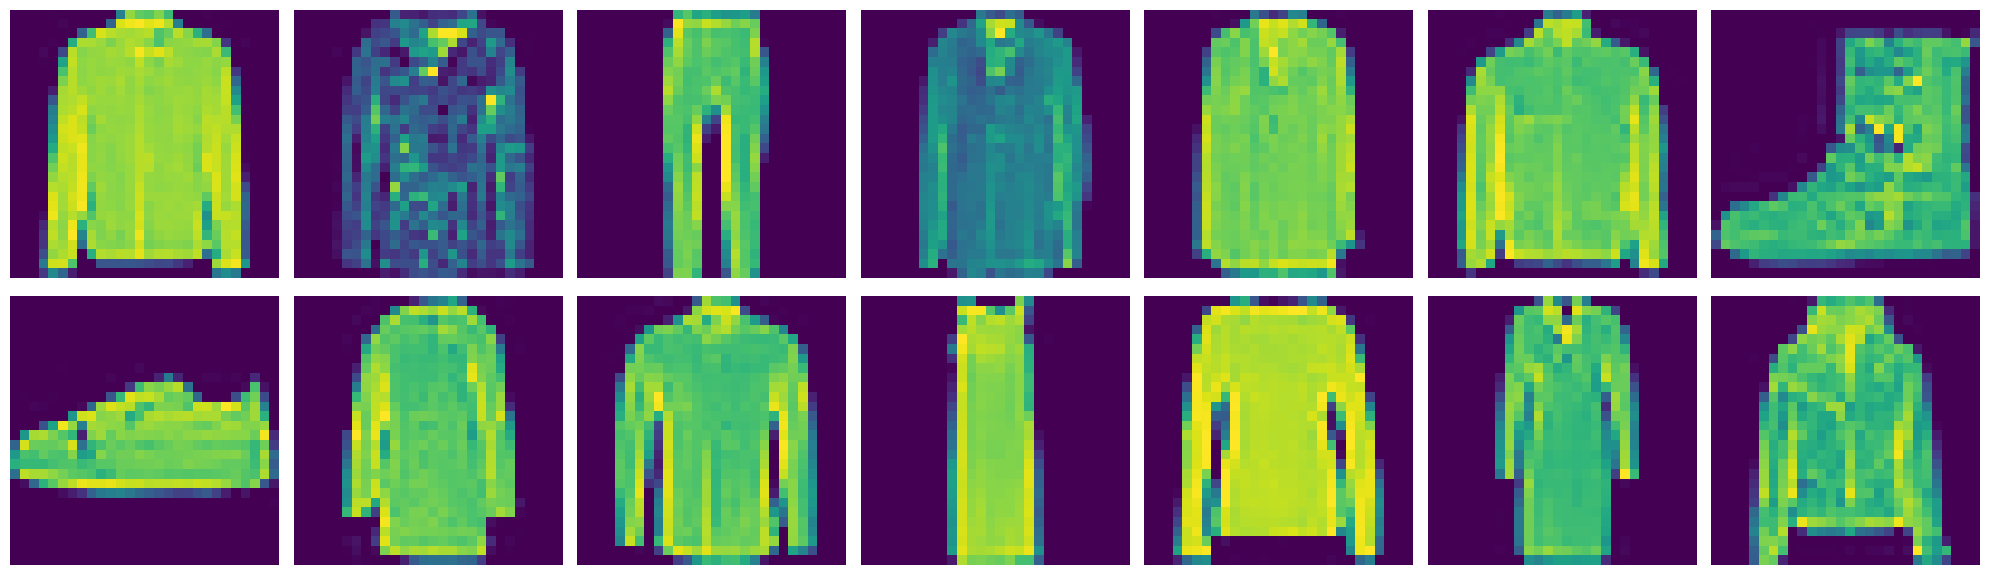

In [4]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

fig = plt.figure(figsize=(20, 6))
for i in range(1, 15):
    fig.add_subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(to_pil_image(samples[i]))
    plt.tight_layout()
plt.savefig('samples.png')

In [5]:
z0, zT = samples[0].reshape(-1), samples[1].reshape(-1)

In [6]:
import torch

from torch_geometry.riemannian.prob_geodesics import ProbGEORCE, ProbEuclideanGEORCE
from torch_geometry.riemannian.prob_geodesics import TorchOptimization, TorchEuclideanOptimization
from torch_geometry.riemannian.manifolds import nSphere

In [7]:
t0 = 0.01
def score_fun(x,t):
    
    x = x.reshape(-1,1,28,28)
    
    score = model(x, t*torch.ones(len(x)))
                   
    return score.reshape(-1)
    

In [13]:
t0 = 0.01
M_ProbGEORCE = ProbEuclideanGEORCE(score_fun = lambda z: score_fun(z,t0),#lambda z: score_fun(z,t0),
                                    init_fun=None,#lambda *args: init_val,#None,
                                    lam=50.0,#,t0**4,
                                    T=100,
                                    max_iter=100,
                                    line_search_params={'rho': 0.5, 'max_iter': 100},
                                   )

In [8]:
t0 = 0.01
M_ProbTorch = TorchEuclideanOptimization(score_fun = lambda z: score_fun(z,t0),#lambda z: score_fun(z,t0),
                                        init_fun=None,#lambda *args: init_val,#None,
                                        lam=50.0,#,t0**4,
                                        T=100,
                                        max_iter=1000,
                                       )

In [14]:
test = M_ProbGEORCE(z0,zT)

99.0243148803711
0
23
72.88067626953125
1
23
67.44002532958984
2
24
54.53993225097656
3
22
52.09662628173828
4
24
48.820735931396484
5
22
48.40644073486328
6
24
46.0296630859375
7
23
45.4530143737793
8
23
45.25167465209961
9
24
44.246700286865234
10
22
44.11481857299805
11
24
42.986515045166016
12
23
42.68165969848633
13
23
42.60103225708008
14
24
41.93260955810547
15
23
41.64175033569336
16
23
41.487850189208984
17
24
41.04520797729492
18
22
40.89260482788086
19
24
40.29848098754883
20
23
40.095314025878906
21
23
40.02592468261719
22
24
39.61077117919922
23
23
39.41057586669922
24
23
39.300907135009766
25
24
38.996856689453125
26
22
38.893028259277344
27
24
38.46025085449219
28
23
38.31311798095703
29
23
38.2701301574707
30
24
37.94854736328125
31
23
37.80027389526367
32
23
37.72618103027344
33
24
37.480098724365234
34
22
37.43107604980469
35
24
37.065128326416016
36
23
36.95584487915039
37
24
36.801021575927734
38
22
36.640140533447266
39
24
36.426170349121094
40
23
36.30784225463867

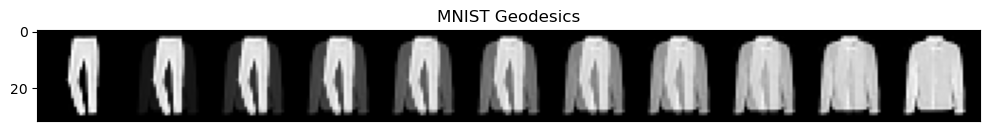

In [15]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test[0].reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()


In [9]:
test2 = M_ProbTorch(z0,zT)

/home/fmry/anaconda3/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0
99.0243148803711
1
282.830810546875
2
117.31920623779297
3
101.22454071044922
4
97.50191497802734
5
95.5267562866211
6
94.69590759277344
7
94.4675521850586
8
94.4475326538086
9
94.28614807128906
10
93.90094757080078
11
93.44122314453125
12
93.02335357666016
13
92.59415435791016
14
91.99830627441406
15
91.20710754394531
16
90.20628356933594
17
89.13528442382812
18
88.11436462402344
19
87.04081726074219
20
85.8677978515625
21
84.62366485595703
22
83.34410858154297
23
82.04678344726562
24
80.73880004882812
25
79.37232971191406
26
78.0160903930664
27
76.64068603515625
28
75.28369140625
29
73.837158203125
30
72.31739044189453
31
70.83919525146484
32
69.42134094238281
33
67.93817901611328
34
66.39512634277344
35
64.93525695800781
36
63.438453674316406
37
61.95106887817383
38
60.43805694580078
39
58.995452880859375
40
57.528621673583984
41
56.072547912597656
42
54.65273666381836
43
53.28057861328125
44
51.93754196166992
45
50.648582458496094
46
49.3156852722168
47
48.109405517578125
48
46.8

369
9.91579818725586
370
9.821325302124023
371
9.883663177490234
372
9.696243286132812
373
9.785080909729004
374
9.675601959228516
375
9.678014755249023
376
9.737751007080078
377
9.743497848510742
378
9.773674011230469
379
9.67474365234375
380
9.744585990905762
381
9.586238861083984
382
9.592954635620117
383
9.717325210571289
384
9.765491485595703
385
9.760879516601562
386
9.762794494628906
387
9.683747291564941
388
9.632495880126953
389
9.62626838684082
390
9.602787017822266
391
9.823362350463867
392
9.596553802490234
393
9.590087890625
394
9.611696243286133
395
9.570714950561523
396
9.573053359985352
397
9.584366798400879
398
9.471290588378906
399
9.493427276611328
400
9.506865501403809
401
9.504247665405273
402
9.53203010559082
403
9.52073860168457
404
9.571308135986328
405
9.478462219238281
406
9.563395500183105
407
9.416772842407227
408
9.529523849487305
409
9.389452934265137
410
9.349655151367188
411
9.406566619873047
412
9.39298152923584
413
9.49041748046875
414
9.52291965484619

745
8.009958267211914
746
8.06596565246582
747
8.123250007629395
748
8.017786979675293
749
8.02403450012207
750
7.953618049621582
751
7.891796112060547
752
7.848543167114258
753
7.840002059936523
754
7.842291831970215
755
7.795960426330566
756
7.912547588348389
757
7.9058613777160645
758
7.977670192718506
759
7.993156433105469
760
7.995633125305176
761
8.053068161010742
762
7.972471237182617
763
7.972986698150635
764
7.915132522583008
765
7.793613910675049
766
7.722159385681152
767
7.651283264160156
768
7.624713897705078
769
7.68015718460083
770
7.650169372558594
771
7.670827388763428
772
7.623035430908203
773
7.650416374206543
774
7.622952461242676
775
7.655324459075928
776
7.695671081542969
777
7.695390224456787
778
7.721684455871582
779
7.805708408355713
780
7.79555082321167
781
7.84443473815918
782
7.815809726715088
783
7.815120220184326
784
7.756875038146973
785
7.715151309967041
786
7.720022201538086
787
7.643038749694824
788
7.689176559448242
789
7.617744445800781
790
7.62312412

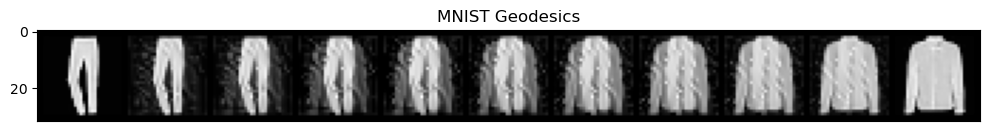

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test2[0].reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()


In [11]:
init_curve = torch.linspace(0.,1.,100+1)[1:-1].reshape(-1,1)*(zT.reshape(-1)-z0.reshape(-1))+z0.reshape(-1)

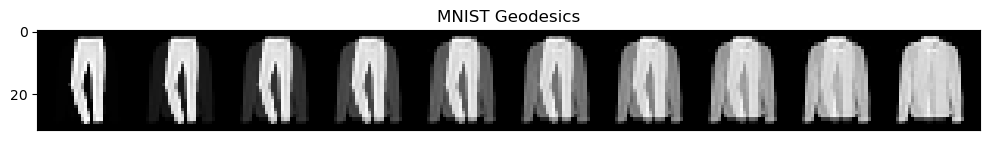

In [12]:



import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(init_curve.reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()
